<a href="https://colab.research.google.com/github/praths007/tensorflow_certification/blob/master/coursera_practise/TS_week3_tuning_ts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.3.0'

In [3]:
import json
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [18]:
def window_dataset(series, window_size, batch_size, shuffle_buffer_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, 1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window:window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
# dataset = window_dataset(series, window_size, shuffle_buffer_size, batch_size)

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = window_dataset(x_train, window_size, 128, shuffle_buffer_size)

model = tf.keras.models.Sequential([Lambda(
  lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 20ms/step - loss: 36.2695 - mae: 36.7671
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 36.1705 - mae: 36.6680
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 36.0162 - mae: 36.5137
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 35.8232 - mae: 36.3202
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 35.5995 - mae: 36.0960
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 35.3458 - mae: 35.8428
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 35.0660 - mae: 35.5622
Epoch 8/100
8/8 [==============================] - 0s 19ms/step - loss: 34.7528 - mae: 35.2491
Epoch 9/100
8/8 [==============================] - 0s 19ms/step - loss: 34.3999 - mae: 34.8967
Epoch 10/100
8/8 [==============================] - 0s 19ms/step - loss: 33.9975 - mae: 34.4944
Epoch 11/100
8/8 [==============================]

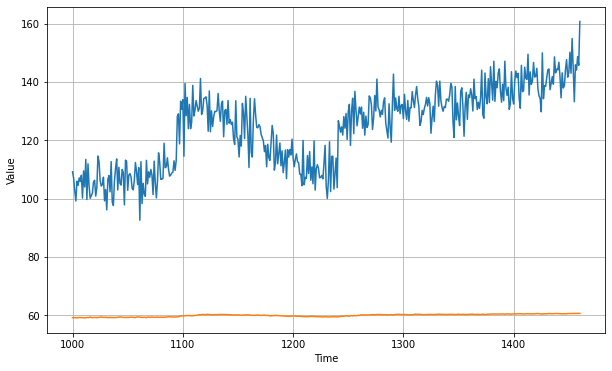

In [27]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

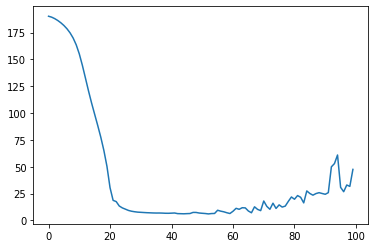

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
# plt.axis(1e-7, 1e-3, 0, 20)

(1e-08, 0.0001, 0.0, 30.0)

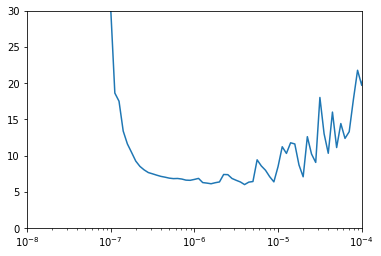

In [10]:
import matplotlib.pyplot as plt
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [11]:
tf.keras.backend.clear_session()

dataset = window_dataset(x_train, window_size, 128, shuffle_buffer_size)


model = Sequential([
                    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                    SimpleRNN(40, return_sequences=True),
                    SimpleRNN(40),
                    Dense(1),
                    Lambda(lambda x:x*100)
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 40)          1680      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [13]:
sgd_opt = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
# callback = tf.keras.callbacks(
    
# )


model.compile(optimizer=sgd_opt, loss=tf.keras.losses.Huber(), metrics=['mae'])

history = model.fit(dataset, epochs=100, verbose=0)

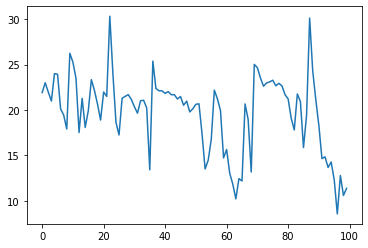

In [14]:
plt.plot(history.history['loss'])

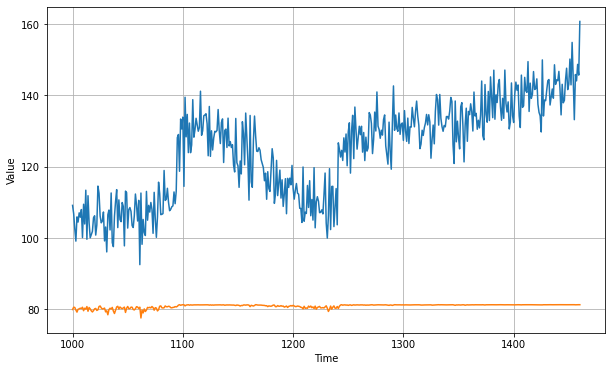

In [15]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

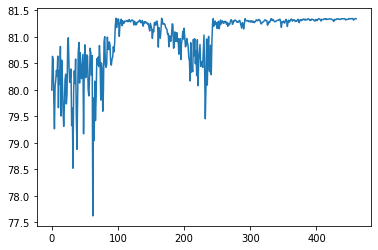

In [16]:
plt.plot(results)